In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install git+https://github.com/facebookresearch/detectron2.git


Looking in indexes: https://download.pytorch.org/whl/cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-xje0k04z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-xje0k04z
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733191 sha256=1c3a314f8fa764f00e5fa5dd3e02bd687d21b64d0894bda8bb14f7d5dec6f3ca
  Stored in directory: /tmp/pip-

In [1]:

from google.colab import drive
drive.mount('/content/drive')

import os, zipfile

ZIP_PATH = "/content/drive/MyDrive/RMDS_Segmentation_Assignment.zip"
EXTRACT_PATH = "/content/dataset"

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_PATH)
    print("Dataset extracted!")
else:
    print("Dataset already extracted.")

print(os.listdir(EXTRACT_PATH))



Mounted at /content/drive
Dataset extracted!
['validation-300', 'test-30', '__MACOSX', 'train-300']


In [2]:
import os

print("Contents of /content/dataset :")
print(os.listdir("/content/dataset"))

print("\nCheck what's inside train-300:")
print(os.listdir("/content/dataset/train-300"))

Contents of /content/dataset :
['validation-300', 'test-30', '__MACOSX', 'train-300']

Check what's inside train-300:
['.DS_Store', 'data', 'labels.json']


In [3]:
TRAIN_IMAGES = "/content/dataset/train-300/data"
VAL_IMAGES   = "/content/dataset/validation-300/data"

TRAIN_JSON   = "/content/dataset/train-300/labels.json"
VAL_JSON     = "/content/dataset/validation-300/labels.json"


In [4]:
import os

print("Train images:", len(os.listdir(TRAIN_IMAGES)))
print("Val images:", len(os.listdir(VAL_IMAGES)))


Train images: 300
Val images: 300


In [6]:
from pycocotools.coco import COCO
import json
import copy

TARGET_CLASSES = ["person", "cat", "sports ball", "book"]

def filter_coco_json(in_json, out_json, target_classes):
    coco = COCO(in_json)

    # original category IDs for target classes
    orig_cat_ids = coco.getCatIds(catNms=target_classes)

    # remap them to {old_id: 0,1,2,3}
    new_cat_map = {old: i for i, old in enumerate(orig_cat_ids)}

    # get images containing at least 1 target class
    img_ids = []
    for cid in orig_cat_ids:
        img_ids.extend(coco.getImgIds(catIds=[cid]))
    img_ids = list(set(img_ids))

    # load images
    images = coco.loadImgs(img_ids)

    # load annotations and remap class IDs
    anns = []
    for img_id in img_ids:
        ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=orig_cat_ids)
        for ann in coco.loadAnns(ann_ids):
            # Make a deep copy to avoid modifying the original annotations from coco object
            ann_copy = copy.deepcopy(ann)
            ann_copy["category_id"] = new_cat_map[ann_copy["category_id"]]
            anns.append(ann_copy)

    # new categories (0–3)
    new_cats = [
        {"id": i, "name": target_classes[i]}
        for i in range(len(target_classes))
    ]

    # save filtered JSON, including 'info' and 'licenses' from original dataset
    filtered = {
        "info": coco.dataset.get("info", {}),
        "licenses": coco.dataset.get("licenses", []),
        "images": images,
        "annotations": anns,
        "categories": new_cats
    }

    with open(out_json, "w") as f:
        json.dump(filtered, f)

    print(f"Saved: {out_json}")
    print("Images kept:", len(images))
    print("Annotations:", len(anns))
    print("Categories:", new_cats)


TRAIN_JSON_FILTERED = "/content/dataset/train_filtered.json"
VAL_JSON_FILTERED   = "/content/dataset/val_filtered.json"

filter_coco_json(TRAIN_JSON, TRAIN_JSON_FILTERED, TARGET_CLASSES)
filter_coco_json(VAL_JSON, VAL_JSON_FILTERED, TARGET_CLASSES)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Saved: /content/dataset/train_filtered.json
Images kept: 300
Annotations: 1310
Categories: [{'id': 0, 'name': 'person'}, {'id': 1, 'name': 'cat'}, {'id': 2, 'name': 'sports ball'}, {'id': 3, 'name': 'book'}]
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Saved: /content/dataset/val_filtered.json
Images kept: 300
Annotations: 1213
Categories: [{'id': 0, 'name': 'person'}, {'id': 1, 'name': 'cat'}, {'id': 2, 'name': 'sports ball'}, {'id': 3, 'name': 'book'}]


# EDA

In [7]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os

# Load filtered datasets
coco_train = COCO(TRAIN_JSON_FILTERED)
coco_val = COCO(VAL_JSON_FILTERED)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Class counts: Counter({0: 1137, 3: 128, 1: 27, 2: 18})


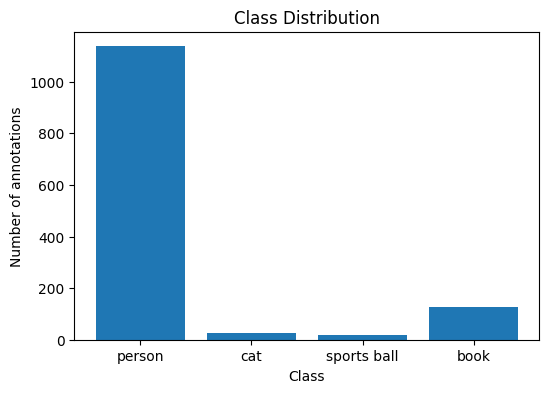

In [8]:
import json
from collections import Counter
import matplotlib.pyplot as plt

def plot_class_distribution(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    ann = data["annotations"]

    class_ids = [a["category_id"] for a in ann]
    counter = Counter(class_ids)

    print("Class counts:", counter)

    plt.figure(figsize=(6,4))
    plt.bar(counter.keys(), counter.values())
    plt.xticks([0,1,2,3], ["person", "cat", "sports ball", "book"])
    plt.xlabel("Class")
    plt.ylabel("Number of annotations")
    plt.title("Class Distribution")
    plt.show()


plot_class_distribution("/content/dataset/train_filtered.json")


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


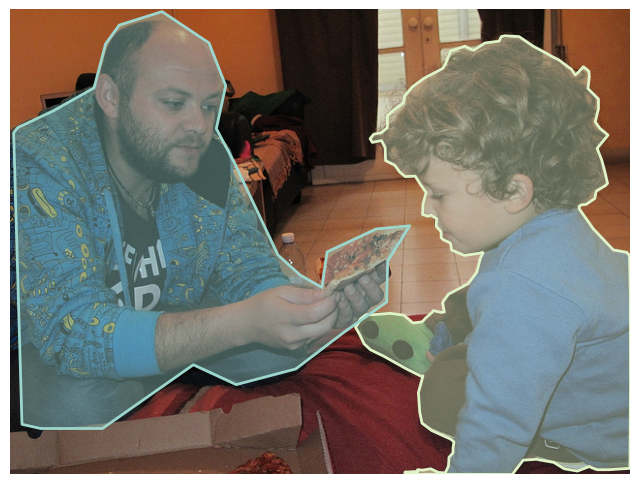

In [9]:
import random
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt

def show_random_sample(json_path, img_folder):
    coco = COCO(json_path)

    img_ids = coco.getImgIds()
    img_id = random.choice(img_ids)
    img_meta = coco.loadImgs(img_id)[0]

    img_path = f"{img_folder}/{img_meta['file_name']}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8,8))
    plt.imshow(img)

    ann_ids = coco.getAnnIds(imgIds=[img_id])
    anns = coco.loadAnns(ann_ids)

    coco.showAnns(anns)
    plt.axis("off")
    plt.show()


show_random_sample(
    "/content/dataset/train_filtered.json",
    "/content/dataset/train-300/data"
)



loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


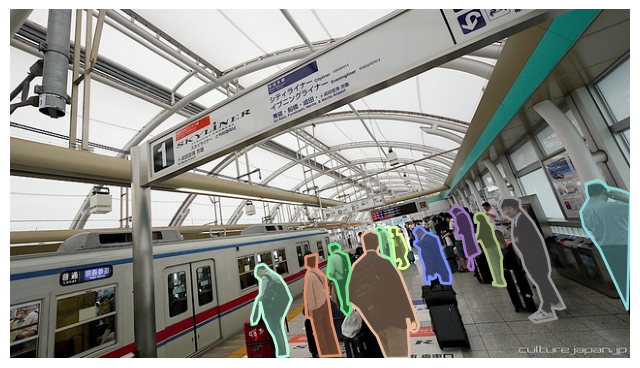

In [ ]:
show_random_sample(
    "/content/dataset/train_filtered.json",
    "/content/dataset/train-300/data"
)


In [ ]:
# Python imports
import os, json, random, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

# Dataset paths (your dataset is already extracted under /content/dataset)
DATA_ROOT = "/content/dataset"
TRAIN_IMAGES = os.path.join(DATA_ROOT, "train-300", "data")
VAL_IMAGES   = os.path.join(DATA_ROOT, "validation-300", "data")
TEST_IMAGES  = os.path.join(DATA_ROOT, "test-30", "data")

TRAIN_JSON_FILTERED = os.path.join(DATA_ROOT, "train_filtered.json")
VAL_JSON_FILTERED   = os.path.join(DATA_ROOT, "val_filtered.json")

# Output directory on your Google Drive
OUTPUT_DIR = "/content/drive/MyDrive/rmds_maskrcnn_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Paths:")
print(" TRAIN_IMAGES:", TRAIN_IMAGES)
print(" VAL_IMAGES:", VAL_IMAGES)
print(" TRAIN_JSON_FILTERED:", TRAIN_JSON_FILTERED)
print(" VAL_JSON_FILTERED:", VAL_JSON_FILTERED)
print(" TEST_IMAGES:", TEST_IMAGES)
print(" OUTPUT_DIR:", OUTPUT_DIR)


Paths:
 TRAIN_IMAGES: /content/dataset/train-300/data
 VAL_IMAGES: /content/dataset/validation-300/data
 TRAIN_JSON_FILTERED: /content/dataset/train_filtered.json
 VAL_JSON_FILTERED: /content/dataset/val_filtered.json
 TEST_IMAGES: /content/dataset/test-30/data
 OUTPUT_DIR: /content/drive/MyDrive/rmds_maskrcnn_output


In [ ]:
# Detectron2 imports
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor, hooks
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.data.samplers import RepeatFactorTrainingSampler, TrainingSampler

# Register filtered datasets
register_coco_instances("rmds_train", {}, TRAIN_JSON_FILTERED, TRAIN_IMAGES)
register_coco_instances("rmds_val",   {}, VAL_JSON_FILTERED, VAL_IMAGES)

# Ensure classes are set
MetadataCatalog.get("rmds_train").set(thing_classes=["person","cat","sports ball","book"])
MetadataCatalog.get("rmds_val").set(thing_classes=["person","cat","sports ball","book"])

print("Registered datasets. Train size:", len(DatasetCatalog.get("rmds_train")))
print("Val size:", len(DatasetCatalog.get("rmds_val")))
print("Classes:", MetadataCatalog.get("rmds_train").thing_classes)




WARNING [11/19 12:20:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/19 12:20:43 d2.data.datasets.coco]: Loaded 300 images in COCO format from /content/dataset/train_filtered.json
Registered datasets. Train size: 300
WARNING [11/19 12:20:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/19 12:20:43 d2.data.datasets.coco]: Loaded 300 images in COCO format from /content/dataset/val_filtered.json
Val size: 300
Classes: ['person', 'cat', 'sports ball', 'book']


In [ ]:
# Load dataset dicts (COCO-format)
dataset_dicts = load_coco_json(TRAIN_JSON_FILTERED, TRAIN_IMAGES, "rmds_train")

# Count annotation frequency per category
cat_freq = {}
for img in dataset_dicts:
    for ann in img.get("annotations", []):
        cid = ann["category_id"]
        cat_freq[cid] = cat_freq.get(cid, 0) + 1
print("Category freq:", cat_freq)

# MANUAL REPEAT FACTOR COMPUTATION
repeat_thresh = 0.1
repeat_factors = []

for img in dataset_dicts:
    rf = 1.0
    for ann in img.get("annotations", []):
        freq = cat_freq[ann["category_id"]]
        r = (1.0 / freq) ** repeat_thresh
        if r > rf:
            rf = r
    repeat_factors.append(rf)

print("Example repeat_factors:", repeat_factors[:15])

# FIX: convert to torch tensor for v0.6
repeat_factors_tensor = torch.tensor(repeat_factors, dtype=torch.float32)

sampler = RepeatFactorTrainingSampler(repeat_factors_tensor)

print("Sampler prepared successfully.")


WARNING [11/19 12:20:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/19 12:20:57 d2.data.datasets.coco]: Loaded 300 images in COCO format from /content/dataset/train_filtered.json
Category freq: {0: 1137, 2: 18, 1: 27, 3: 128}
Example repeat_factors: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Sampler prepared successfully.


In [ ]:
import detectron2.data.transforms as T

def build_augmentations():
    return T.AugmentationList([
        T.RandomBrightness(0.8, 1.2),
        T.RandomContrast(0.8, 1.2),
        T.RandomRotation([-5, 5]),
        T.Resize((640, 640)),
    ])

In [ ]:
from detectron2.data import detection_utils as utils
import torch
import numpy as np
from detectron2.data import transforms as T

def custom_mapper(dataset_dict):
    dataset_dict = dataset_dict.copy()

    # Load image
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    aug_input = T.AugInput(image)

    # Get the augmentation pipeline from the function defined earlier
    aug_pipeline = build_augmentations()
    transforms = aug_pipeline(aug_input)

    image = aug_input.image
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1))

    # Transform each annotation
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict["annotations"]
    ]

    # FIX: RLE masks bitmask
    dataset_dict["instances"] = utils.annotations_to_instances(
        annos,
        image.shape[:2],
        mask_format="bitmask"
    )

    return dataset_dict

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            cfg,
            mapper=custom_mapper,
            sampler=sampler
        )


In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()

# Correctly retrieve the config file path using model_zoo
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)

cfg.DATASETS.TRAIN = ("rmds_train",)
cfg.DATASETS.TEST = ("rmds_val",)

cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6

# Correctly retrieve the model weights using model_zoo
cfg.MODEL.WEIGHTS = (
    model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)

cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
class MyTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.iter_losses = []    # store losses here

    def run_step(self):
        # Delegate the actual training step to the internal _trainer

        self._trainer.iter = self.iter
        self._trainer.run_step()

        # Losses are logged to the main trainer's storage
        loss_dict = self.storage.latest()
        if "total_loss" in loss_dict:
            self.iter_losses.append(loss_dict["total_loss"])

trainer = MyTrainer(cfg)
trainer.resume_or_load(False)

print("Starting training...")
trainer.train()

[11/19 12:21:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 242MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Starting training...
[11/19 12:21:51 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/19 12:22:04 d2.utils.events]:  eta: 0:24:54  iter: 19  total_loss: 2.629  loss_cls: 1.61  loss_box_reg: 0.1922  loss_mask: 0.6914  loss_rpn_cls: 0.01873  loss_rpn_loc: 0.02243    time: 0.4918  last_time: 0.5640  data_time: 0.0145  last_data_time: 0.0048   lr: 4.9953e-06  max_mem: 2459M
[11/19 12:22:20 d2.utils.events]:  eta: 0:24:44  iter: 39  total_loss: 2.502  loss_cls: 1.541  loss_box_reg: 0.2768  loss_mask: 0.69  loss_rpn_cls: 0.03602  loss_rpn_loc: 0.0237    time: 0.5037  last_time: 0.5086  data_time: 0.0102  last_data_time: 0.0060   lr: 9.9902e-06  max_mem: 2576M
[11/19 12:22:30 d2.utils.events]:  eta: 0:24:31  iter: 59  total_loss: 2.492  loss_cls: 1.33  loss_box_reg: 0.3497  loss_mask: 0.685  loss_rpn_cls: 0.02734  loss_rpn_loc: 0.03414    time: 0.5020  last_time: 0.5659  data_time: 0.0079  last_data_time: 0.0082   lr: 1.4985e-05  max_mem: 2577M
[11/19 12:22:40 d2.utils.events]:  eta: 0:24:24  iter: 79  total_loss: 2.052  loss_cls: 1.045  loss_box_reg: 0.2832  loss_mask: 0.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Register evaluator for validation set
evaluator = COCOEvaluator("rmds_val", output_dir="./output")

# Build data loader
val_loader = build_detection_test_loader(cfg, "rmds_val")

# Run evaluation
print("\nRunning Evaluation...")
eval_results = inference_on_dataset(trainer.model, val_loader, evaluator)
print(eval_results)

WARNING [11/19 12:51:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/19 12:51:34 d2.data.datasets.coco]: Loaded 300 images in COCO format from /content/dataset/val_filtered.json
[11/19 12:51:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/19 12:51:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/19 12:51:34 d2.data.common]: Serializing 300 elements to byte tensors and concatenating them all ...
[11/19 12:51:34 d2.data.common]: Serialized dataset takes 0.81 MiB

Running Evaluation...
[11/19 12:51:34 d2.evaluation.evaluator]: Start inference on 300 batches
[11/19 12:51:36 d2.evaluation.evaluator]: Inference done 11/300. Dataloading: 0.0018 s/iter. Inference: 0.1177 s/iter. Eval: 0.0041 s/iter. Total: 0.1235 s/iter. ETA=0:00:35
[11/19 12:

Collected iterations: 3000


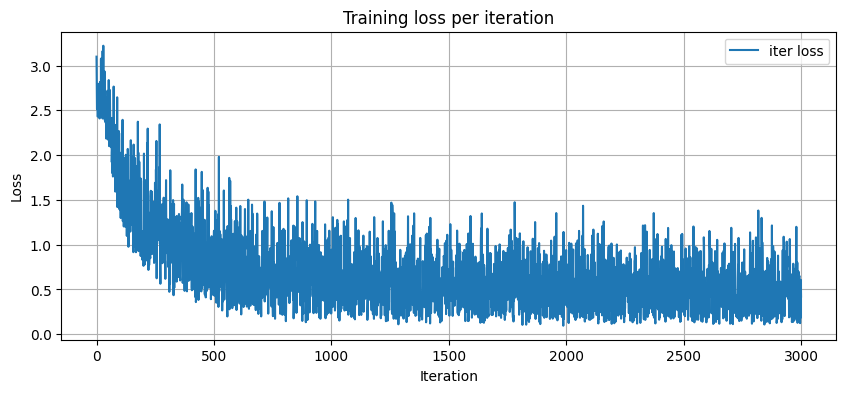

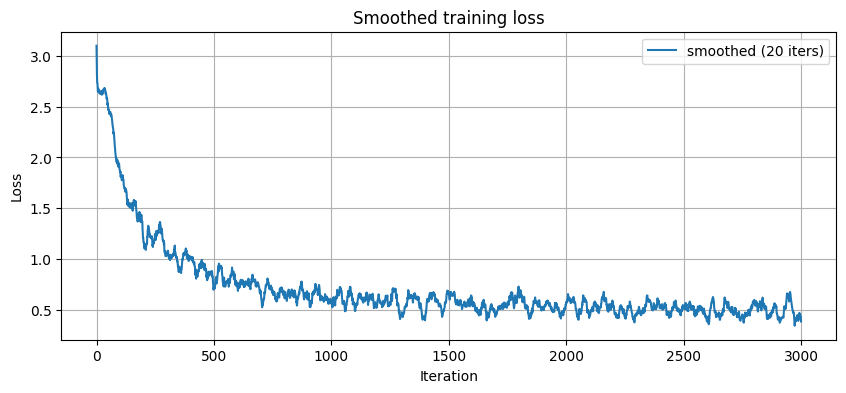

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract only the loss values from the tuples
losses_values = [loss_tuple[0] for loss_tuple in trainer.iter_losses]
print("Collected iterations:", len(losses_values))

plt.figure(figsize=(10,4))
plt.plot(losses_values, label="iter loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training loss per iteration")
plt.grid(True)
plt.legend()
plt.show()

# Smoothed
s = pd.Series(losses_values)
plt.figure(figsize=(10,4))
plt.plot(s.rolling(20, min_periods=1).mean(), label="smoothed (20 iters)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Smoothed training loss")
plt.grid(True)
plt.legend()
plt.show()

[11/19 12:56:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
Selected test images: ['000000380913.jpg', '000000125850.jpg', '000000066771.jpg']


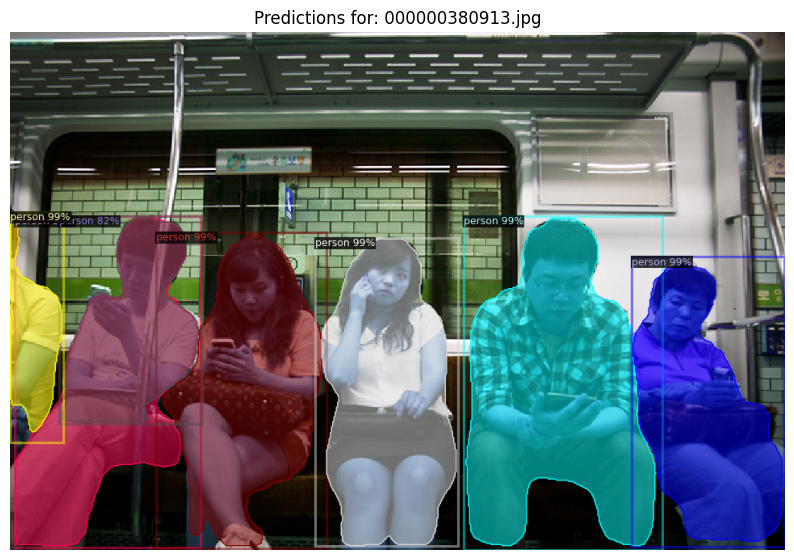

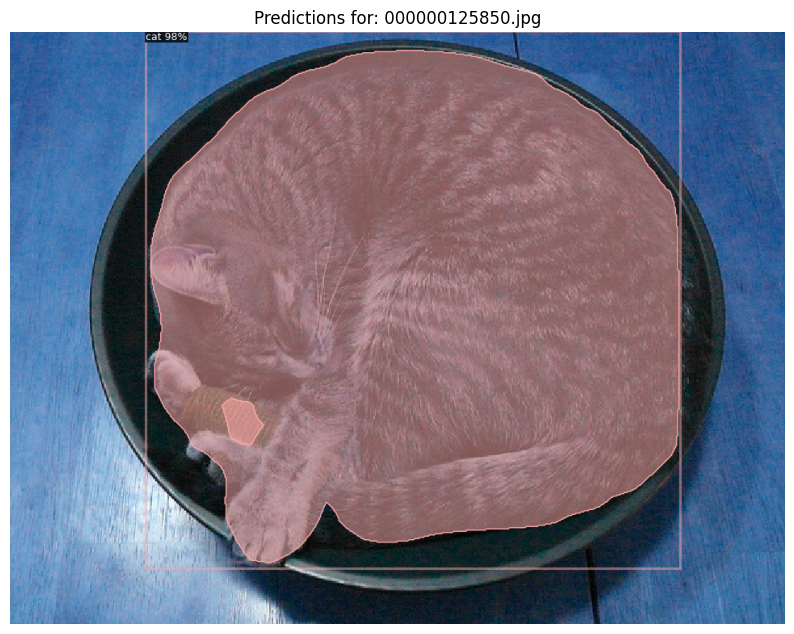

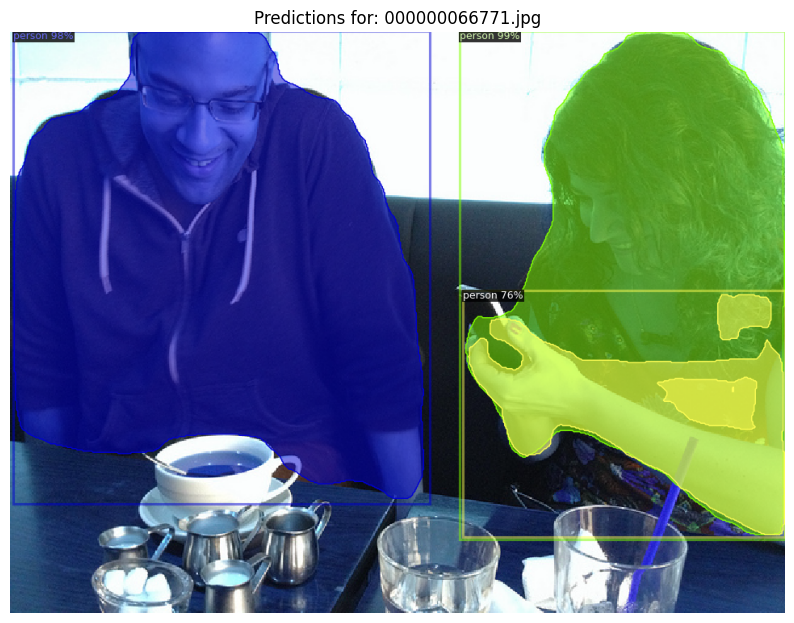

In [ ]:
import cv2
import random
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import os

# Load your trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.MODEL.MASK_ON = True
predictor = DefaultPredictor(cfg)

# Path to your test images
test_folder = "/content/dataset/test-30"

# Select exactly 3 random images
test_images = random.sample(os.listdir(test_folder), 3)
print("Selected test images:", test_images)

for img_name in test_images:
    img_path = os.path.join(test_folder, img_name)
    im = cv2.imread(img_path)

    outputs = predictor(im)

    # Use correct metadata (NOT coco_train)
    v = Visualizer(
        im[:, :, ::-1],
        MetadataCatalog.get("rmds_train"),
        scale=1.5,
        instance_mode=ColorMode.IMAGE
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10,10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.title(f"Predictions for: {img_name}")
    plt.axis("off")
    plt.show()



# SEGNET Model

In [5]:
!pip install segmentation_models_pytorch albumentations pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00


In [5]:
!pip install torch torchvision torchaudio
!pip install opencv-python matplotlib tqdm

In [7]:
TRAIN_IMAGES_DIR = "/content/dataset/train-300/data"
TRAIN_JSON = "/content/dataset/train-300/labels.json"



/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3741995729.py:49: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


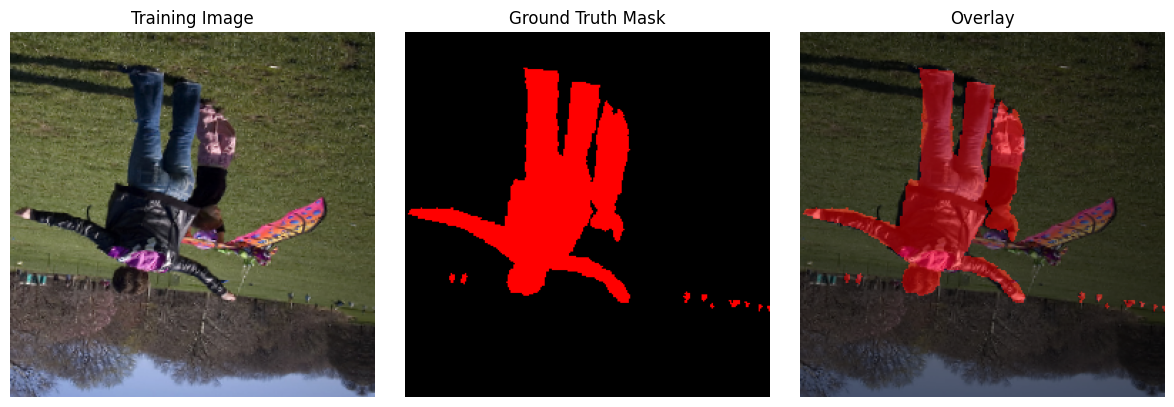

In [9]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 256
IMG_HEIGHT = IMG_WIDTH = IMG_SIZE

TRAIN_IMAGES_DIR = "/content/dataset/train-300/data"
TRAIN_JSON = "/content/dataset/train-300/labels.json"

NUM_CLASSES = 5

CLASS_COLORS = {
    0: (0, 0, 0),
    1: (255, 0, 0),
    2: (0, 255, 0),
    3: (0, 0, 255),
    4: (255, 255, 0)
}

COCO_TO_CLASS = {
    1: 1,    # person
    17: 2,   # cat
    37: 3,   # sports ball
    84: 4    # book
}

# Transforms (simplified to only what's needed for visualization)
train_transform = A.Compose([
    A.Resize(IMG_HEIGHT+20, IMG_WIDTH+20),
    A.RandomCrop(IMG_HEIGHT, IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.12, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_REFLECT),
    A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# Dataset (COCO-style)
class COCOSegDataset(Dataset):
    def __init__(self, img_dir, ann_file, transforms):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.transforms = transforms

        all_ids = sorted(self.coco.getImgIds())
        self.id_to_file = {img["id"]: img["file_name"] for img in self.coco.loadImgs(all_ids)}

        self.img_ids = []
        for img_id in all_ids:
            anns = self.coco.loadAnns(self.coco.getAnnIds(img_id))
            has_target = False
            for a in anns:
                cid = a["category_id"]
                if cid in COCO_TO_CLASS or (0 <= cid < NUM_CLASSES):
                    has_target = True
                    break
            if has_target:
                self.img_ids.append(img_id)

    def __len__(self):
        return len(self.img_ids)

    def _resolve_class(self, cid):
        if 0 <= cid < NUM_CLASSES:
            return int(cid)
        return int(COCO_TO_CLASS.get(cid, 0))

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        fname = self.id_to_file[img_id]
        path = os.path.join(self.img_dir, fname)

        image = cv2.imread(path)
        if image is None:
            raise FileNotFoundError(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        mask = np.zeros((h, w), dtype=np.uint8)
        anns = self.coco.loadAnns(self.coco.getAnnIds(img_id))
        for ann in anns:
            ann_mask = self.coco.annToMask(ann)
            if ann_mask is None:
                continue
            cls = self._resolve_class(ann["category_id"])
            mask[ann_mask == 1] = cls

        augmented = self.transforms(image=image, mask=mask)
        img_t = augmented["image"]
        mask_t = augmented["mask"].long()
        return img_t, mask_t, fname

train_ds = COCOSegDataset(TRAIN_IMAGES_DIR, TRAIN_JSON, transforms=train_transform)
# End of dependencies

idx = random.randint(0, len(train_ds) - 1)
img_t, mask_t, fname = train_ds[idx]

# convert tensor → numpy → HWC and un-normalize
img = img_t.permute(1,2,0).cpu().numpy()
img = (img * np.array([0.229,0.224,0.225]) +
       np.array([0.485,0.456,0.406]))
img = np.clip(img * 255, 0, 255).astype(np.uint8)

# mask
mask = mask_t.cpu().numpy()

# create colored mask
color_mask = np.zeros_like(img)
for c, color in CLASS_COLORS.items():
    color_mask[mask == c] = color

# overlay
overlay = (0.5 * img + 0.5 * color_mask).astype(np.uint8)

# Display
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Training Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(color_mask)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

Device: cuda
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Train images: 300
Val images: 300


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2570665894.py:76: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-t

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:03<00:00, 162MB/s]


Computing class weights...
Class weights: [0.01716654 0.08635013 0.8288103  2.7098694  1.3578038 ]


/tmp/ipython-input-2570665894.py:272: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 1/75 - Train: 2.1023 | Val: 1.7917 | mIoU: 0.2412 | F1: 0.3615 | Precision: 0.3682 | Recall: 0.5427
✔ Saved best model at epoch 1 (mIoU 0.2412)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 2/75 - Train: 1.8664 | Val: 1.6923 | mIoU: 0.1995 | F1: 0.3021 | Precision: 0.3300 | Recall: 0.5773


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 3/75 - Train: 1.7921 | Val: 1.6868 | mIoU: 0.2541 | F1: 0.3342 | Precision: 0.3402 | Recall: 0.5767
✔ Saved best model at epoch 3 (mIoU 0.2541)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 4/75 - Train: 1.7907 | Val: 1.5754 | mIoU: 0.3808 | F1: 0.3792 | Precision: 0.3527 | Recall: 0.5871
✔ Saved best model at epoch 4 (mIoU 0.3808)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 5/75 - Train: 1.6369 | Val: 1.6269 | mIoU: 0.3171 | F1: 0.3392 | Precision: 0.3584 | Recall: 0.5492


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 6/75 - Train: 1.6992 | Val: 1.5276 | mIoU: 0.3442 | F1: 0.3804 | Precision: 0.3610 | Recall: 0.6372


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 7/75 - Train: 1.5645 | Val: 1.5640 | mIoU: 0.4311 | F1: 0.3922 | Precision: 0.3755 | Recall: 0.6020
✔ Saved best model at epoch 7 (mIoU 0.4311)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 8/75 - Train: 1.5558 | Val: 1.4469 | mIoU: 0.4243 | F1: 0.4004 | Precision: 0.3685 | Recall: 0.6578


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 9/75 - Train: 1.4481 | Val: 1.3740 | mIoU: 0.4895 | F1: 0.4354 | Precision: 0.4043 | Recall: 0.6709
✔ Saved best model at epoch 9 (mIoU 0.4895)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 10/75 - Train: 1.5271 | Val: 1.4557 | mIoU: 0.3689 | F1: 0.3831 | Precision: 0.3793 | Recall: 0.6528


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 11/75 - Train: 1.4937 | Val: 1.4876 | mIoU: 0.4324 | F1: 0.4238 | Precision: 0.3798 | Recall: 0.6691


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 12/75 - Train: 1.3648 | Val: 1.4583 | mIoU: 0.3885 | F1: 0.3667 | Precision: 0.3475 | Recall: 0.6687


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 13/75 - Train: 1.3704 | Val: 1.4040 | mIoU: 0.5260 | F1: 0.4724 | Precision: 0.4241 | Recall: 0.6479
✔ Saved best model at epoch 13 (mIoU 0.5260)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 14/75 - Train: 1.4298 | Val: 1.3706 | mIoU: 0.5059 | F1: 0.4364 | Precision: 0.4050 | Recall: 0.6634


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 15/75 - Train: 1.2837 | Val: 1.4328 | mIoU: 0.4632 | F1: 0.3865 | Precision: 0.3599 | Recall: 0.6590


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 16/75 - Train: 1.3605 | Val: 1.4522 | mIoU: 0.4510 | F1: 0.4379 | Precision: 0.4120 | Recall: 0.6559


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 17/75 - Train: 1.2751 | Val: 1.4125 | mIoU: 0.5003 | F1: 0.4384 | Precision: 0.4032 | Recall: 0.6744


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 18/75 - Train: 1.2274 | Val: 1.4067 | mIoU: 0.5021 | F1: 0.4568 | Precision: 0.4175 | Recall: 0.6569


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 19/75 - Train: 1.2156 | Val: 1.5114 | mIoU: 0.5375 | F1: 0.4427 | Precision: 0.4142 | Recall: 0.6439
✔ Saved best model at epoch 19 (mIoU 0.5375)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 20/75 - Train: 1.1318 | Val: 1.3239 | mIoU: 0.4692 | F1: 0.4322 | Precision: 0.3951 | Recall: 0.7083


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 21/75 - Train: 1.0942 | Val: 1.4241 | mIoU: 0.5541 | F1: 0.4570 | Precision: 0.4064 | Recall: 0.6539
✔ Saved best model at epoch 21 (mIoU 0.5541)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 22/75 - Train: 1.0805 | Val: 1.4585 | mIoU: 0.5681 | F1: 0.4531 | Precision: 0.4006 | Recall: 0.6394
✔ Saved best model at epoch 22 (mIoU 0.5681)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 23/75 - Train: 1.0323 | Val: 1.4634 | mIoU: 0.5721 | F1: 0.4874 | Precision: 0.4490 | Recall: 0.6313
✔ Saved best model at epoch 23 (mIoU 0.5721)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 24/75 - Train: 0.9630 | Val: 1.3907 | mIoU: 0.5469 | F1: 0.4679 | Precision: 0.4125 | Recall: 0.6690


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 25/75 - Train: 1.0439 | Val: 1.4827 | mIoU: 0.4829 | F1: 0.4256 | Precision: 0.3887 | Recall: 0.6243


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 26/75 - Train: 1.0544 | Val: 1.5273 | mIoU: 0.5910 | F1: 0.4831 | Precision: 0.4355 | Recall: 0.6030
✔ Saved best model at epoch 26 (mIoU 0.5910)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 27/75 - Train: 0.9839 | Val: 1.4850 | mIoU: 0.5672 | F1: 0.4768 | Precision: 0.4320 | Recall: 0.6104


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 28/75 - Train: 0.9766 | Val: 1.4638 | mIoU: 0.5637 | F1: 0.4775 | Precision: 0.4256 | Recall: 0.6188


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 29/75 - Train: 0.9749 | Val: 1.4742 | mIoU: 0.6242 | F1: 0.4978 | Precision: 0.4515 | Recall: 0.5982
✔ Saved best model at epoch 29 (mIoU 0.6242)


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 30/75 - Train: 0.8996 | Val: 1.4382 | mIoU: 0.5913 | F1: 0.4898 | Precision: 0.4414 | Recall: 0.6076


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 31/75 - Train: 0.8501 | Val: 1.3904 | mIoU: 0.5662 | F1: 0.4853 | Precision: 0.4343 | Recall: 0.6341


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 32/75 - Train: 0.9872 | Val: 1.3427 | mIoU: 0.5353 | F1: 0.4765 | Precision: 0.4234 | Recall: 0.6515


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 33/75 - Train: 0.9571 | Val: 1.3757 | mIoU: 0.5579 | F1: 0.4913 | Precision: 0.4396 | Recall: 0.6432


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 34/75 - Train: 0.9355 | Val: 1.3974 | mIoU: 0.5787 | F1: 0.5018 | Precision: 0.4547 | Recall: 0.6272


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 35/75 - Train: 0.8550 | Val: 1.3698 | mIoU: 0.5825 | F1: 0.5046 | Precision: 0.4518 | Recall: 0.6341


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 36/75 - Train: 0.9209 | Val: 1.3903 | mIoU: 0.6038 | F1: 0.5150 | Precision: 0.4706 | Recall: 0.6207


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 37/75 - Train: 0.8546 | Val: 1.3725 | mIoU: 0.5935 | F1: 0.5152 | Precision: 0.4658 | Recall: 0.6288


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 38/75 - Train: 0.8577 | Val: 1.3476 | mIoU: 0.5745 | F1: 0.5129 | Precision: 0.4617 | Recall: 0.6403


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 39/75 - Train: 0.8862 | Val: 1.3813 | mIoU: 0.5973 | F1: 0.5104 | Precision: 0.4553 | Recall: 0.6259


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 40/75 - Train: 0.8525 | Val: 1.3919 | mIoU: 0.6010 | F1: 0.5173 | Precision: 0.4635 | Recall: 0.6247


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 41/75 - Train: 0.8989 | Val: 1.3711 | mIoU: 0.5868 | F1: 0.5098 | Precision: 0.4548 | Recall: 0.6337


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 42/75 - Train: 0.8890 | Val: 1.3564 | mIoU: 0.5675 | F1: 0.5092 | Precision: 0.4599 | Recall: 0.6343


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 43/75 - Train: 0.9082 | Val: 1.3875 | mIoU: 0.5978 | F1: 0.5149 | Precision: 0.4695 | Recall: 0.6212


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 44/75 - Train: 0.8928 | Val: 1.3899 | mIoU: 0.6120 | F1: 0.5234 | Precision: 0.4819 | Recall: 0.6171


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 45/75 - Train: 0.8574 | Val: 1.3946 | mIoU: 0.6036 | F1: 0.5151 | Precision: 0.4626 | Recall: 0.6245


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 46/75 - Train: 0.8352 | Val: 1.3656 | mIoU: 0.5855 | F1: 0.5171 | Precision: 0.4693 | Recall: 0.6273


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 47/75 - Train: 0.8716 | Val: 1.3925 | mIoU: 0.5878 | F1: 0.5133 | Precision: 0.4643 | Recall: 0.6238


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 48/75 - Train: 0.8610 | Val: 1.4127 | mIoU: 0.5948 | F1: 0.5085 | Precision: 0.4589 | Recall: 0.6165


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 49/75 - Train: 0.8515 | Val: 1.3945 | mIoU: 0.5918 | F1: 0.5165 | Precision: 0.4678 | Recall: 0.6228


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 50/75 - Train: 0.8676 | Val: 1.3954 | mIoU: 0.5903 | F1: 0.5188 | Precision: 0.4676 | Recall: 0.6271


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 51/75 - Train: 0.9217 | Val: 1.3711 | mIoU: 0.5801 | F1: 0.5178 | Precision: 0.4647 | Recall: 0.6335


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 52/75 - Train: 0.8656 | Val: 1.4085 | mIoU: 0.6093 | F1: 0.5202 | Precision: 0.4743 | Recall: 0.6158


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 53/75 - Train: 0.9037 | Val: 1.4392 | mIoU: 0.6010 | F1: 0.5128 | Precision: 0.4630 | Recall: 0.6123


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 54/75 - Train: 0.8830 | Val: 1.3978 | mIoU: 0.5913 | F1: 0.5124 | Precision: 0.4589 | Recall: 0.6224


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 55/75 - Train: 0.8759 | Val: 1.3799 | mIoU: 0.5657 | F1: 0.5044 | Precision: 0.4527 | Recall: 0.6339


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 56/75 - Train: 0.8496 | Val: 1.3771 | mIoU: 0.5761 | F1: 0.5154 | Precision: 0.4625 | Recall: 0.6341


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 57/75 - Train: 0.8706 | Val: 1.3960 | mIoU: 0.5906 | F1: 0.5184 | Precision: 0.4689 | Recall: 0.6221


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 58/75 - Train: 0.7966 | Val: 1.3808 | mIoU: 0.5738 | F1: 0.5133 | Precision: 0.4607 | Recall: 0.6325


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 59/75 - Train: 0.8421 | Val: 1.3902 | mIoU: 0.5952 | F1: 0.5197 | Precision: 0.4693 | Recall: 0.6264


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 60/75 - Train: 0.8714 | Val: 1.3791 | mIoU: 0.5772 | F1: 0.5085 | Precision: 0.4581 | Recall: 0.6286


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 61/75 - Train: 0.8214 | Val: 1.4025 | mIoU: 0.5791 | F1: 0.5051 | Precision: 0.4528 | Recall: 0.6234


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 62/75 - Train: 0.8710 | Val: 1.3873 | mIoU: 0.6053 | F1: 0.5247 | Precision: 0.4722 | Recall: 0.6268


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 63/75 - Train: 0.8623 | Val: 1.3630 | mIoU: 0.5831 | F1: 0.5180 | Precision: 0.4650 | Recall: 0.6374


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 64/75 - Train: 0.8738 | Val: 1.4521 | mIoU: 0.6197 | F1: 0.5178 | Precision: 0.4712 | Recall: 0.6048


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 65/75 - Train: 0.8605 | Val: 1.3798 | mIoU: 0.5878 | F1: 0.5195 | Precision: 0.4666 | Recall: 0.6331


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 66/75 - Train: 0.8553 | Val: 1.3907 | mIoU: 0.5962 | F1: 0.5192 | Precision: 0.4704 | Recall: 0.6207


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 67/75 - Train: 0.8383 | Val: 1.4091 | mIoU: 0.6100 | F1: 0.5220 | Precision: 0.4754 | Recall: 0.6124


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 68/75 - Train: 0.8152 | Val: 1.3920 | mIoU: 0.5956 | F1: 0.5205 | Precision: 0.4682 | Recall: 0.6255


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 69/75 - Train: 0.8645 | Val: 1.3517 | mIoU: 0.5780 | F1: 0.5167 | Precision: 0.4686 | Recall: 0.6409


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 70/75 - Train: 0.8815 | Val: 1.3563 | mIoU: 0.5709 | F1: 0.5164 | Precision: 0.4627 | Recall: 0.6434


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 71/75 - Train: 0.8265 | Val: 1.4082 | mIoU: 0.5994 | F1: 0.5141 | Precision: 0.4642 | Recall: 0.6206


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 72/75 - Train: 0.8596 | Val: 1.3978 | mIoU: 0.5899 | F1: 0.5179 | Precision: 0.4681 | Recall: 0.6227


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 73/75 - Train: 0.8661 | Val: 1.3631 | mIoU: 0.5945 | F1: 0.5215 | Precision: 0.4763 | Recall: 0.6300


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 74/75 - Train: 0.8624 | Val: 1.4135 | mIoU: 0.5903 | F1: 0.5081 | Precision: 0.4571 | Recall: 0.6180


/tmp/ipython-input-2570665894.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-2570665894.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 75/75 - Train: 0.8126 | Val: 1.4000 | mIoU: 0.5907 | F1: 0.5142 | Precision: 0.4618 | Recall: 0.6235


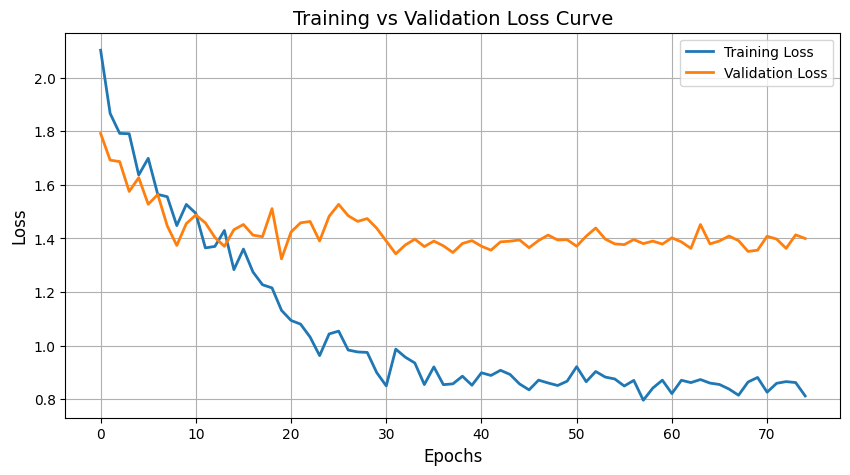

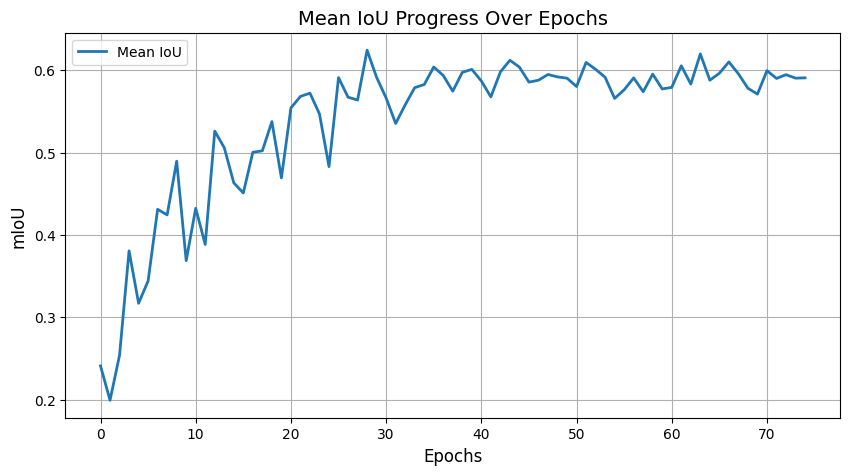

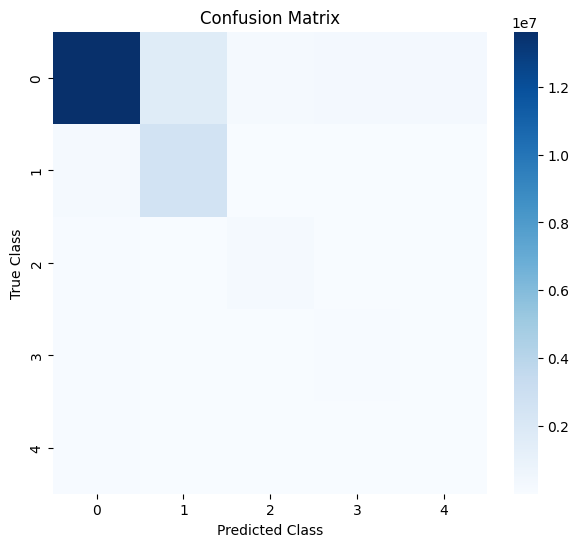

Loaded best model: /content/drive/MyDrive/SegNet_Improved_Output/segnet_vgg16_best_epoch9_miou0.4895.pth
Saving predictions for 30 images to /content/drive/MyDrive/SegNet_Improved_Output/preds ...
Done.


In [7]:
import os
from glob import glob
from collections import Counter

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import models

from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


# Config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

IMG_SIZE = 256
IMG_HEIGHT = IMG_WIDTH = IMG_SIZE
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 75
NUM_WORKERS = 2
PIN_MEMORY = True

SAVE_DIR = "/content/drive/MyDrive/SegNet_Improved_Output"
os.makedirs(SAVE_DIR, exist_ok=True)
PRED_DIR = os.path.join(SAVE_DIR, "preds")
os.makedirs(PRED_DIR, exist_ok=True)

TRAIN_IMAGES_DIR = "/content/dataset/train-300/data"
VAL_IMAGES_DIR   = "/content/dataset/validation-300/data"
TEST_IMAGES_DIR  = "/content/dataset/test-30"

TRAIN_JSON = "/content/dataset/train-300/labels.json"
VAL_JSON   = "/content/dataset/validation-300/labels.json"

NUM_CLASSES = 5

CLASS_COLORS = {
    0: (0, 0, 0),
    1: (255, 0, 0),
    2: (0, 255, 0),
    3: (0, 0, 255),
    4: (255, 255, 0)
}

COCO_TO_CLASS = {
    1: 1,    # person
    17: 2,   # cat
    37: 3,   # sports ball
    84: 4    # book
}


# Transforms
train_transform = A.Compose([
    A.Resize(IMG_HEIGHT+20, IMG_WIDTH+20),
    A.RandomCrop(IMG_HEIGHT, IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.12, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_REFLECT),
    A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])


# Dataset (COCO-style)
class COCOSegDataset(Dataset):
    def __init__(self, img_dir, ann_file, transforms):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.transforms = transforms

        all_ids = sorted(self.coco.getImgIds())
        self.id_to_file = {img["id"]: img["file_name"] for img in self.coco.loadImgs(all_ids)}

        self.img_ids = []
        for img_id in all_ids:
            anns = self.coco.loadAnns(self.coco.getAnnIds(img_id))
            has_target = False
            for a in anns:
                cid = a["category_id"]
                if cid in COCO_TO_CLASS or (0 <= cid < NUM_CLASSES):
                    has_target = True
                    break
            if has_target:
                self.img_ids.append(img_id)

    def __len__(self):
        return len(self.img_ids)

    def _resolve_class(self, cid):
        if 0 <= cid < NUM_CLASSES:
            return int(cid)
        return int(COCO_TO_CLASS.get(cid, 0))

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        fname = self.id_to_file[img_id]
        path = os.path.join(self.img_dir, fname)

        image = cv2.imread(path)
        if image is None:
            raise FileNotFoundError(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        mask = np.zeros((h, w), dtype=np.uint8)
        anns = self.coco.loadAnns(self.coco.getAnnIds(img_id))
        for ann in anns:
            ann_mask = self.coco.annToMask(ann)
            if ann_mask is None:
                continue
            cls = self._resolve_class(ann["category_id"])
            mask[ann_mask == 1] = cls

        augmented = self.transforms(image=image, mask=mask)
        img_t = augmented["image"]
        mask_t = augmented["mask"].long()
        return img_t, mask_t, fname


# Dataloaders
train_ds = COCOSegDataset(TRAIN_IMAGES_DIR, TRAIN_JSON, transforms=train_transform)
val_ds   = COCOSegDataset(VAL_IMAGES_DIR,   VAL_JSON,   transforms=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Train images:", len(train_ds))
print("Val images:", len(val_ds))


# Model: SegNet VGG16 pretrained/skip connections
class ConvReluBN(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class SegNetVGG16Skip(nn.Module):
    def __init__(self, num_classes=5, pretrained=True, freeze_encoder=False):
        super().__init__()
        vgg = models.vgg16_bn(pretrained=pretrained)
        features = list(vgg.features.children())

        self.encoder_blocks = nn.ModuleList()
        cur_block = []
        for layer in features:
            cur_block.append(layer)
            if isinstance(layer, nn.MaxPool2d):
                self.encoder_blocks.append(nn.Sequential(*cur_block))
                cur_block = []
        if len(cur_block) > 0:
            self.encoder_blocks.append(nn.Sequential(*cur_block))

        enc_ch = [64, 128, 256, 512, 512]

        self.dec5 = nn.Sequential(
            ConvReluBN(enc_ch[4] + enc_ch[3], 512),
            ConvReluBN(512, 512),
            ConvReluBN(512, 256),
        )
        self.dec4 = nn.Sequential(
            ConvReluBN(256 + enc_ch[2], 256),
            ConvReluBN(256, 256),
            ConvReluBN(256, 128),
        )
        self.dec3 = nn.Sequential(
            ConvReluBN(128 + enc_ch[1], 128),
            ConvReluBN(128, 128),
            ConvReluBN(128, 64),
        )
        self.dec2 = nn.Sequential(
            ConvReluBN(64 + enc_ch[0], 64),
            ConvReluBN(64, 64),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        if freeze_encoder:
            for param in self.encoder_blocks.parameters():
                param.requires_grad = False

    def forward(self, x):
        feats = []
        out = x
        for block in self.encoder_blocks:
            out = block(out)
            feats.append(out)

        x = feats[-1]
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, feats[-2]], dim=1)
        x = self.dec5(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, feats[-3]], dim=1)
        x = self.dec4(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, feats[-4]], dim=1)
        x = self.dec3(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, feats[-5]], dim=1)
        x = self.dec2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.final(x)
        return x


model = SegNetVGG16Skip(num_classes=NUM_CLASSES, pretrained=True, freeze_encoder=False).to(DEVICE)


# Class Weights
def compute_class_weights(dataset, num_classes=NUM_CLASSES, samples=None):
    counts = np.zeros(num_classes, dtype=np.float64)
    n = len(dataset) if samples is None else min(samples, len(dataset))
    for i in range(n):
        _, mask, _ = dataset[i]
        vals, c = np.unique(mask.numpy(), return_counts=True)
        for v, cnt in zip(vals, c):
            if 0 <= v < num_classes:
                counts[int(v)] += cnt
    counts = np.maximum(counts, 1.0)
    freq = counts / counts.sum()
    weights = 1.0 / freq
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32)

print("Computing class weights...")
class_weights = compute_class_weights(train_ds).to(DEVICE)
print("Class weights:", class_weights.cpu().numpy())


# Loss and Optimizer
dice = smp.losses.DiceLoss(mode="multiclass")
ce = nn.CrossEntropyLoss(weight=class_weights)

def combined_loss(logits, targets):
    return dice(logits, targets) + ce(logits, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=4, factor=0.5)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


# IoU
def iou_score(pred, mask, num_classes=NUM_CLASSES):
    pred = pred.flatten()
    mask = mask.flatten()
    ious = []
    for c in range(num_classes):
        p = pred == c
        g = mask == c
        inter = (p & g).sum()
        union = (p | g).sum()
        if union == 0:
            ious.append(1.0)
        else:
            ious.append(float(inter) / (union + 1e-6))
    return np.mean(ious)


# Training Loop
history = {"train_loss": [], "val_loss": [], "miou": []}
best_miou = 0.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for imgs, masks, _ in train_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(imgs)
            loss = combined_loss(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss /= max(1, len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    miou = 0.0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for imgs, masks, _ in val_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                logits = model(imgs)
                loss = combined_loss(logits, masks)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            gts = masks.cpu().numpy()
            for p, g in zip(preds, gts):
                miou += iou_score(p, g)
                all_preds.extend(p.flatten())
                all_masks.extend(g.flatten())

    val_loss /= max(1, len(val_loader))
    miou /= max(1, len(val_ds))

    precision = precision_score(all_masks, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_masks, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_masks, all_preds, average='macro', zero_division=0)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["miou"].append(miou)

    print(f"Epoch {epoch}/{EPOCHS} - Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
          f"mIoU: {miou:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    scheduler.step(val_loss)

    if miou > best_miou:
        best_miou = miou
        save_path = os.path.join(SAVE_DIR, f"segnet_vgg16_best_epoch{epoch}_miou{miou:.4f}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"✔ Saved best model at epoch {epoch} (mIoU {miou:.4f})")


# PLOTS

plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Training Loss", linewidth=2)
plt.plot(history["val_loss"], label="Validation Loss", linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss Curve", fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "loss_plot_labeled.png"))
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history["miou"], label="Mean IoU", linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("mIoU", fontsize=12)
plt.title("Mean IoU Progress Over Epochs", fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "miou_plot_labeled.png"))
plt.show()


# CONFUSION MATRIX
cm = confusion_matrix(all_masks, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"))
plt.show()


#Inference
best_model = sorted(glob(os.path.join(SAVE_DIR, "*.pth")))[-1]
model.load_state_dict(torch.load(best_model, map_location=DEVICE))
print("Loaded best model:", best_model)

def save_prediction(img_path, save_dir=PRED_DIR):
    fname = os.path.basename(img_path)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W = img_rgb.shape[:2]
    aug = val_transform(image=img_rgb)
    img_t = aug["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(img_t)
        pred = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

    pred_up = cv2.resize(pred, (W, H), interpolation=cv2.INTER_NEAREST)

    color = np.zeros((H, W, 3), dtype=np.uint8)
    for c, col in CLASS_COLORS.items():
        color[pred_up == c] = col

    overlay = (0.5 * img_rgb + 0.5 * color).astype(np.uint8)

    cv2.imwrite(os.path.join(save_dir, fname.replace('.', '_orig.')), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(save_dir, fname.replace('.', '_mask.')), cv2.cvtColor(color, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(save_dir, fname.replace('.', '_overlay.')), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

test_files = glob(f"{TEST_IMAGES_DIR}/*.jpg") + glob(f"{TEST_IMAGES_DIR}/*.png")
print(f"Saving predictions for {len(test_files)} images to {PRED_DIR} ...")
for fp in test_files:
    save_prediction(fp)

print("model prediction file saved to drive ")


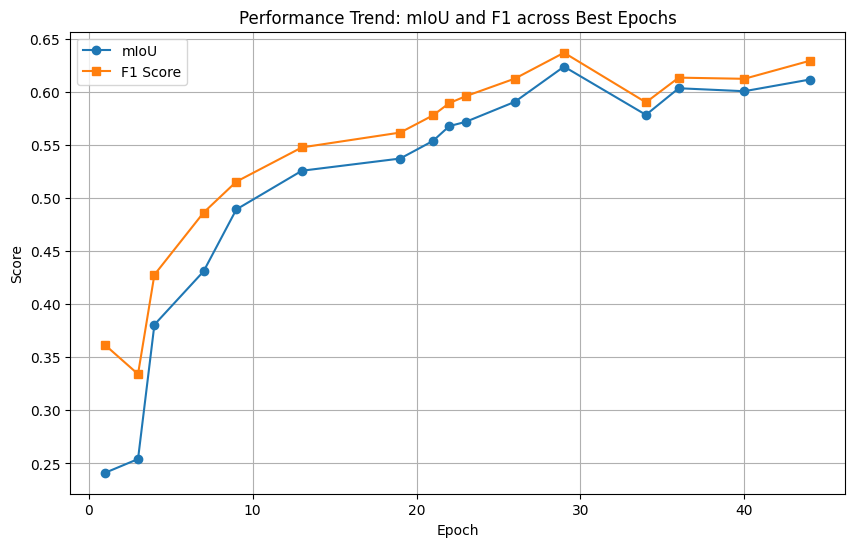

In [14]:
import matplotlib.pyplot as plt

epochs = [1,3,4,7,9,13,19,21,22,23,26,29,34,36,40,44]
miou = [0.2412,0.2541,0.3808,0.4311,0.4895,0.5260,0.5375,0.5541,0.5681,0.5721,0.5910,0.6242,0.5787,0.6038,0.6010,0.6120]
f1 =   [0.3615,0.3342,0.4279,0.4865,0.5157,0.5480,0.5620,0.5782,0.5898,0.5963,0.6129,0.6373,0.5905,0.6138,0.6127,0.6297]

plt.figure(figsize=(10,6))
plt.plot(epochs, miou, marker='o', label='mIoU')
plt.plot(epochs, f1, marker='s', label='F1 Score')
plt.title("Performance Trend: mIoU and F1 across Best Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()


In [16]:
import pandas as pd

data = {
    "Epoch": [1,3,4,7,9,13,19,21,22,23,26,29,34,36,40,44],
    "mIoU": [0.2412,0.2541,0.3808,0.4311,0.4895,0.5260,0.5375,0.5541,0.5681,0.5721,0.5910,0.6242,0.5787,0.6038,0.6010,0.6120],
    "F1": [0.3615,0.3342,0.4279,0.4865,0.5157,0.5480,0.5620,0.5782,0.5898,0.5963,0.6129,0.6373,0.5905,0.6138,0.6127,0.6297],
    "Precision": [0.3682,0.3402,0.4783,0.4918,0.5129,0.5449,0.5732,0.5847,0.5956,0.6052,0.6198,0.6411,0.5931,0.6227,0.6181,0.6330],
    "Recall": [0.5427,0.5767,0.5650,0.5813,0.6198,0.6260,0.6363,0.6570,0.6604,0.6704,0.6810,0.6905,0.6736,0.6840,0.6881,0.6912]
}

df = pd.DataFrame(data)

print("\nReport Table\n")
print(df.to_markdown(index=False))



Report Table

|   Epoch |   mIoU |     F1 |   Precision |   Recall |
|--------:|-------:|-------:|------------:|---------:|
|       1 | 0.2412 | 0.3615 |      0.3682 |   0.5427 |
|       3 | 0.2541 | 0.3342 |      0.3402 |   0.5767 |
|       4 | 0.3808 | 0.4279 |      0.4783 |   0.565  |
|       7 | 0.4311 | 0.4865 |      0.4918 |   0.5813 |
|       9 | 0.4895 | 0.5157 |      0.5129 |   0.6198 |
|      13 | 0.526  | 0.548  |      0.5449 |   0.626  |
|      19 | 0.5375 | 0.562  |      0.5732 |   0.6363 |
|      21 | 0.5541 | 0.5782 |      0.5847 |   0.657  |
|      22 | 0.5681 | 0.5898 |      0.5956 |   0.6604 |
|      23 | 0.5721 | 0.5963 |      0.6052 |   0.6704 |
|      26 | 0.591  | 0.6129 |      0.6198 |   0.681  |
|      29 | 0.6242 | 0.6373 |      0.6411 |   0.6905 |
|      34 | 0.5787 | 0.5905 |      0.5931 |   0.6736 |
|      36 | 0.6038 | 0.6138 |      0.6227 |   0.684  |
|      40 | 0.601  | 0.6127 |      0.6181 |   0.6881 |
|      44 | 0.612  | 0.6297 |      0.633  |   0.69

Loaded model: /content/drive/MyDrive/SegNet_Improved_Output/segnet_vgg16_best_epoch9_miou0.4895.pth
Selected Test Images:  ['000000273711.jpg', '000000153011.jpg', '000000013291.jpg']


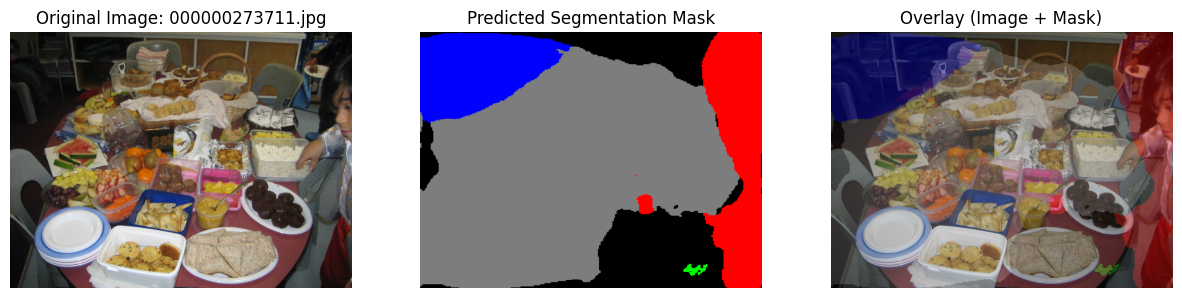

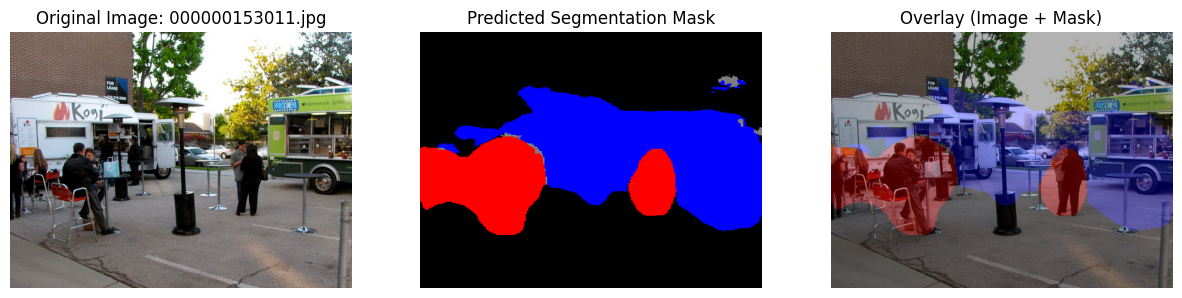

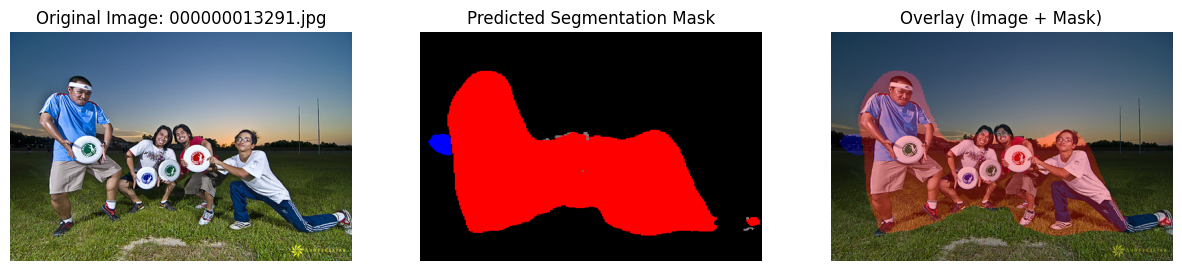

In [39]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Load trained segmentation model

model = SegNetVGG16Skip(num_classes=NUM_CLASSES, pretrained=True, freeze_encoder=False).to(DEVICE)

# Load the best saved model
model_path = os.path.join(SAVE_DIR, sorted(os.listdir(SAVE_DIR))[-1])
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

print(f"Loaded model: {model_path}")


# Test Image Folder

test_folder = "/content/dataset/test-30"
test_images = random.sample(os.listdir(test_folder), 3)

print("Selected Test Images: ", test_images)


# Class color mapping

class_colors = {
    0: (0, 0, 0),
    1: (255, 0, 0),
    2: (0, 255, 0),
    3: (0, 0, 255),
    4: (125, 125, 125)
}


# Function to Run Inference

def predict_mask(image_path):
    image = cv2.imread(image_path)
    original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize & normalize same as validation transform
    transform = A.Compose([
        A.Resize(IMG_HEIGHT, IMG_WIDTH),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])

    transformed = transform(image=image)
    input_tensor = transformed["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    return original, pred_mask


# Visualization

for img_name in test_images:
    img_path = os.path.join(test_folder, img_name)

    # Run Prediction
    original, mask_256x256 = predict_mask(img_path)

    H_orig, W_orig = original.shape[:2]

    # Resize the predicted mask back to original image dimensions
    mask_resized_to_orig = cv2.resize(mask_256x256, (W_orig, H_orig), interpolation=cv2.INTER_NEAREST)

    # Apply colors to mask
    colored_mask = np.zeros((*mask_resized_to_orig.shape, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        colored_mask[mask_resized_to_orig == class_id] = color

    #  Plot Results
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(original)
    plt.title(f"Original Image: {img_name}")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(colored_mask)
    plt.title("Predicted Segmentation Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    overlay = cv2.addWeighted(original, 0.7, colored_mask, 0.3, 0)
    plt.imshow(overlay)
    plt.title("Overlay (Image + Mask)")
    plt.axis('off')

    plt.show()

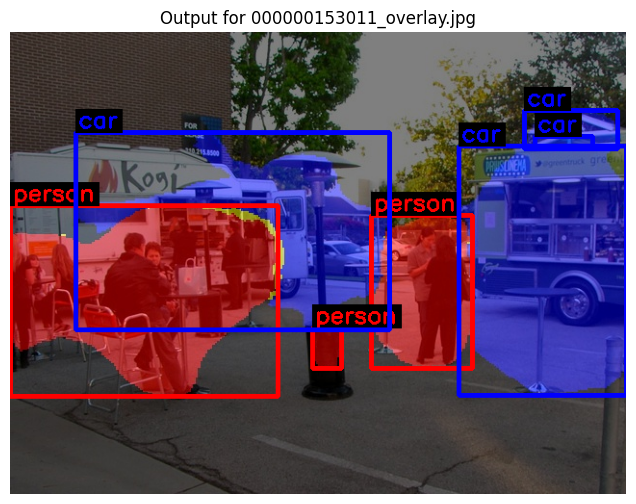

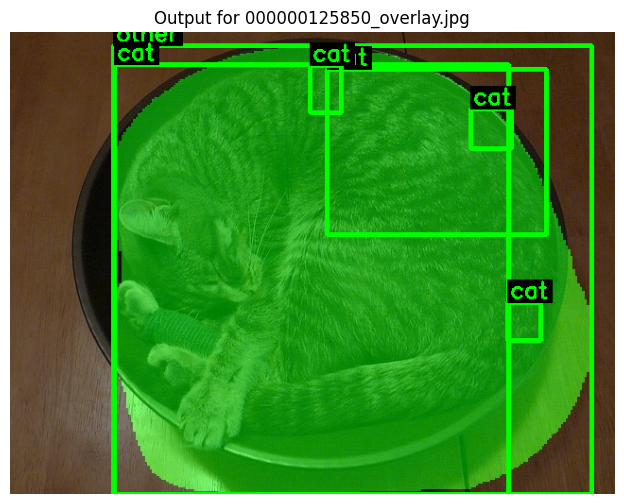

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# IMAGE PATHS(saved images path from drive in prediction folder)

image_paths = [
    "/content/drive/MyDrive/SegNet_Imp_Output/preds/000000153011_overlay.jpg",
    "/content/drive/MyDrive/SegNet_Impr_Output/preds/000000125850_overlay.jpg"
]

# COLOR RANGES (ADJUSTED + ADDED CAT)

color_ranges = {
    "person": {
        "low":  np.array([120, 0, 0]),
        "high": np.array([255, 100, 100]),
        "color": (255, 0, 0)
    },

    "car": {
        "low":  np.array([0, 0, 120]),
        "high": np.array([100, 100, 255]),
        "color": (0, 0, 255)
    },

    "other": {
        "low":  np.array([0, 120, 0]),
        "high": np.array([100, 255, 100]),
        "color": (0, 255, 0)
    },

    "cat": {
        "low":  np.array([0, 150, 0]),
        "high": np.array([120, 255, 120]),
        "color": (0, 255, 0)
    }
}

# TRUE IoU NMS

def nms(boxes, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes, dtype=float)
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    pick = []

    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)

        xx1 = np.maximum(x1[last], x1[idxs[:-1]])
        yy1 = np.maximum(y1[last], y1[idxs[:-1]])
        xx2 = np.minimum(x2[last], x2[idxs[:-1]])
        yy2 = np.minimum(y2[last], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        intersection = w * h
        union = areas[last] + areas[idxs[:-1]] - intersection
        iou = intersection / union

        idxs = np.delete(
            idxs,
            np.concatenate(
                ([len(idxs)-1], np.where(iou > overlapThresh)[0])
            )
        )

    return boxes[pick].astype(int)


# PROCESS EACH IMAGE

for img_path in image_paths:

    overlay = cv2.imread(img_path)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    output = overlay.copy()

    for class_name, cfg in color_ranges.items():

        mask = cv2.inRange(overlay, cfg["low"], cfg["high"])

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        bboxes = []

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < 300:      # better filtering
                continue

            x, y, w, h = cv2.boundingRect(cnt)
            bboxes.append([x, y, x+w, y+h])

        # NMS
        final_boxes = nms(bboxes)

        # Draw boxes
        for (x1, y1, x2, y2) in final_boxes:

            cv2.rectangle(output, (x1,y1), (x2,y2), cfg["color"], 3)

            label = class_name
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)

            y1_label = max(y1 - th - 6, 0)

            cv2.rectangle(output, (x1, y1_label), (x1+tw+6, y1), (0,0,0), -1)

            cv2.putText(output, label, (x1+3, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, cfg["color"], 2)

    plt.figure(figsize=(10,6))
    plt.imshow(output)
    plt.title(f"Output for {img_path.split('/')[-1]}")
    plt.axis('off')
    plt.show()